# UTKface Analysis
---

## Project Stages
This notebook serves as an implementation for the research discussed in the paper "Detecting and Analyzing Biases in Age Estimation Models: A Comprehensive Evaluation of Datasets and their biases" by Noah Wijnheijmer. This document will serve as a comprehensive implementation of the full analysis of one of the discussed datasets. As described in the afromentioned paper, the following workflow will be used:
 
The document will follow Google's PACE workflow:

- Plan(according to 'Datasheets for Datasets' )
- Analyze
- Construct
- Execute

---
## 1. Plan

### 1.1 Frame the business scenario and problem

Using the methodology highlighed in the supporting paper, the following information has been carefully gathered on the dataset for dataset documentation with regards to Bias analysis:

<details>
<summary>Motivation</summary>
The UTKFace dataset was created to provide a large-scale face dataset with a wide age span for various facial analysis tasks1. The motivation appears to be supporting research in areas like face detection, age estimation, age progression/regression, and landmark localization.


</details>
<details>
<summary>Composition</summary>

- Over 20,000 face images
- Age annotations ranging from 0 to 116 years old
- Gender annotations (male/female)
- Ethnicity annotations (White, Black, Asian, Indian, Others)
- Images with variations in pose, facial expression, illumination, and occlusion

</details>

<details>
<summary>Collection Process</summary>

Images were collected from the internet, specific sources are however unknown (general webscrape)

</details>

<details>
<summary>Preprocessing/Cleaning/Labeling</summary>

- Images were aligned and cropped
- Facial landmarks (68 points) were extracted
- Age, gender, and ethnicity labels were estimated using the DEX algorithm and verified by human annotators

</details>

<details>
<summary>Uses</summary>

Intended uses of the dataset include:
- Face detection
- Age estimation
- Age progression/regression
- Landmark localization
- Gender and ethnicity classification

</details>

<details>
<summary>Distribution</summary>

The dataset is available for non-commercial research purposes and is distributed in various formats:
- In-the-wild faces (1.3GB ZIP file)
- Aligned and cropped faces (107MB ZIP file)
- Landmarks (12MB TXT file)

</details>

<details>
<summary>Maintenance</summary>

The dataset is maintained by the AICIP (Advanced Imaging and Collaborative Information Processing) lab. Contact information for inquiries includes Yang Song or Zhifei Zhang.

</details>


### 1.2 The Dataset

In [1]:
#Stel de directory in
dataset_dir = "UTKFace"  # Directory of the dataset

batch_size = 64
target_size = (128, 128)  # Resize all images to 128x128 pixels

### 1.3 Imports


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import csv
from tkinter import Tk, Label, Button, filedialog, Frame
from PIL import Image, ImageTk
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference


In [3]:
# Check if TensorFlow is built with CUDA (GPU) support
print("Is TensorFlow built with CUDA support?:", tf.test.is_built_with_cuda())

# Check if a GPU device is available
print("Is a GPU available?:", tf.config.list_physical_devices('GPU'))

# List available devices
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Is TensorFlow built with CUDA support?: False
Is a GPU available?: []
Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


### 1.4 EDA


1. Age distribution
2. Gender distribution
3. Ethnic distribution
4. Completeness of annotations
5. ~~Validating~~
6. ~~Presenting~~

## Preprocessing

In [4]:
images = []
ages = []
genders = []
races = []

# Iterate over the images in the directory
for filename in os.listdir(dataset_dir):
    if filename.endswith(".jpg"):
        try:
            # Open the image and resize it to 128x128 pixels
            img = Image.open(os.path.join(dataset_dir, filename))
            img = img.resize(target_size)
            img_array = np.array(img)
            images.append(img_array)
            
            # Check if each photo has age, gender, and race labels
            parts = filename.split("_")
            if len(parts) >= 3:
                age = int(parts[0])
                gender = int(parts[1])
                race = int(parts[2])
                ages.append(age)
                genders.append(gender)
                races.append(race)
            else:
                print(f"Skipping file {filename}: insufficient parts")

        except (ValueError, IndexError) as e:
            # Skip any files that have incorrect formatting or issues
            print(f"Skipping file {filename}: {e}")

# Check if images were collected
if len(images) == 0:
    raise ValueError("No valid images found in the dataset directory.")

# Convert lists to numpy arrays and ensure consistent shapes
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)
races = np.array(races)

# Count occurrences of each class in genders and races
gender_counts = Counter(genders)
race_counts = Counter(races)

# Filter out classes with fewer than 2 members
valid_indices = [i for i, (gender, race) in enumerate(zip(genders, races)) if gender_counts[gender] >= 2 and race_counts[race] >= 2]

# Apply the filter to images, ages, genders, and races
images = images[valid_indices]
ages = ages[valid_indices]
genders = genders[valid_indices]
races = races[valid_indices]

# One-hot encode the gender and race labels
genders = to_categorical(genders)
races = to_categorical(races)

# Split the dataset into training and validation sets
train_images, val_images, train_ages, val_ages, train_genders, val_genders, train_races, val_races = train_test_split(
    images, ages, genders, races, test_size=0.2, random_state=42, stratify=genders
)

# Create a DataFrame for analysis
data = {
    'Image': [img for img in images],
    'Age': ages,
    'Gender': [np.argmax(gender) for gender in genders],  # Convert one-hot encoding back to labels
    'Race': [np.argmax(race) for race in races]  # Convert one-hot encoding back to labels
}

df = pd.DataFrame(data)

# Display the DataFrame
df.head()


Skipping file 39_1_20170116174525125.jpg.chip.jpg: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'
Skipping file 61_1_20170109142408075.jpg.chip.jpg: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Skipping file 61_1_20170109150557335.jpg.chip.jpg: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'


,Image,Age,Gender,Race
0,"[[[214, 205, 200], [211, 202, 197], [195, 186,...",100,0,0
1,"[[[119, 123, 134], [122, 126, 137], [123, 127,...",100,0,0
2,"[[[227, 230, 233], [231, 236, 242], [228, 235,...",100,1,0
3,"[[[78, 82, 93], [78, 82, 93], [78, 82, 93], [7...",100,1,0
4,"[[[65, 69, 80], [67, 71, 82], [68, 72, 83], [6...",100,1,0


In [5]:
#gender and race dictionary
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

---
## 2. Analyze

Main goal of EDA in the analyze stage is to understand the relationships between variables and visualizations are integral in this section

**`Variables of interest should be identified at the start of this stage`**

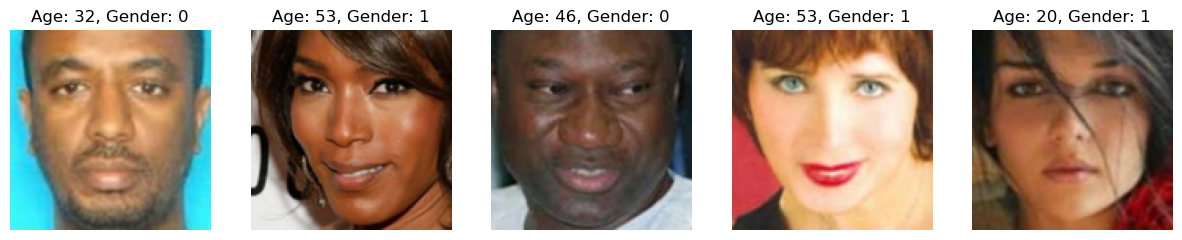

In [6]:
# I display some radnom images with their labels  for visual inspection
indices = np.random.choice(len(train_images), 5, replace=False)
sample_images = train_images[indices]
sample_ages = train_ages[indices]
sample_genders = np.argmax(train_genders[indices], axis=1)  # Convert one-hot encoding back to labels

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i])
    ax.axis('off')
    ax.set_title(f"Age: {sample_ages[i]}, Gender: {sample_genders[i]}")
plt.show()

In [7]:
# Convert one-hot encoded genders back to labels 
if genders.ndim > 1:
    genders = np.argmax(genders, axis=1)

gender_counts = Counter(genders)

# Print the counts
print(f"Number of men: {gender_counts[0]}")
print(f"Number of women: {gender_counts[1]}")

Number of men: 12391
Number of women: 11314


#### gender distribution

In [8]:

male_count = gender_counts[0]
female_count = gender_counts[1]

# Visualization of gender imbalance
gender_mapping = ['Male', 'Female']
pie_chart = px.pie(
    names=gender_mapping,
    values=[male_count, female_count],
    hole=0.4,
    title="Gender Distribution (Donut Chart)",
    height=500
)
pie_chart.show()

bar_graph = px.bar(
    y=gender_mapping,
    x=[male_count, female_count],
    title="Gender Distribution (Bar Graph)",
    color=gender_mapping,
    height=500
)
bar_graph.update_layout(
    yaxis_title="Gender",
    xaxis_title="Frequency Count"
)
bar_graph.show()


#### Age distribution

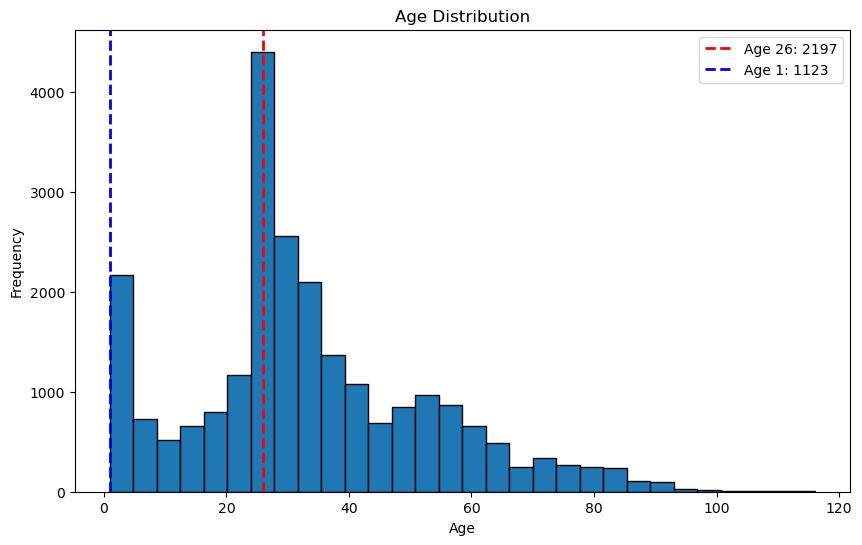

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Highlight the frequency of ages 26 and 1
age_26_count = sum(ages == 26)
age_1_count = sum(ages == 1)

plt.axvline(x=26, color='r', linestyle='--', linewidth=2, label=f'Age 26: {age_26_count}')
plt.axvline(x=1, color='b', linestyle='--', linewidth=2, label=f'Age 1: {age_1_count}')

plt.legend()
plt.show()

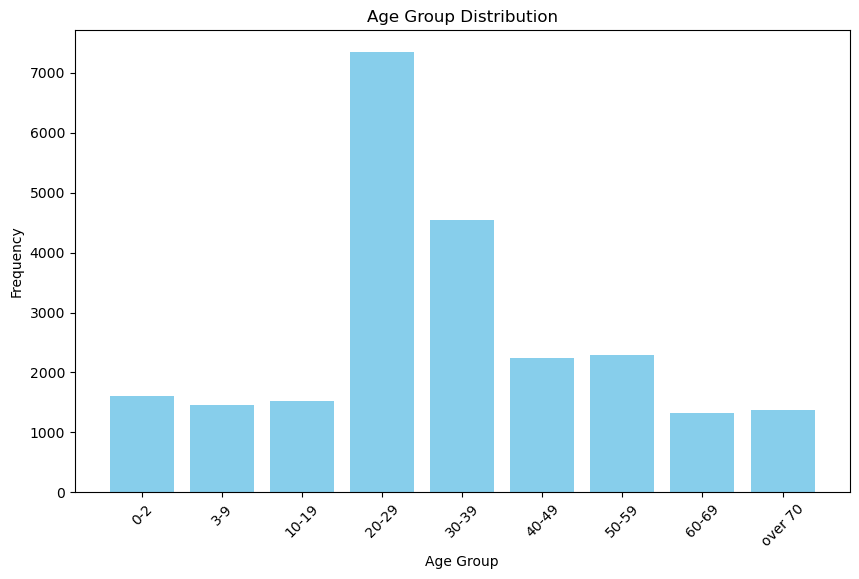

In [10]:
# Define the age groups
age_groups = {
    0: "0-2",
    1: "3-9",
    2: "10-19",
    3: "20-29",
    4: "30-39",
    5: "40-49",
    6: "50-59",
    7: "60-69",
    8: "over 70"
}

# Function to map age to age group
def map_age_to_group(age):
    if age <= 2:
        return 0
    elif age <= 9:
        return 1
    elif age <= 19:
        return 2
    elif age <= 29:
        return 3
    elif age <= 39:
        return 4
    elif age <= 49:
        return 5
    elif age <= 59:
        return 6
    elif age <= 69:
        return 7
    else:
        return 8

# Apply the function to create a new column 'AgeGroup'
df['AgeGroup'] = df['Age'].apply(map_age_to_group)

# Display the updated DataFrame
df.head()

# Display the distribution of age groups
age_group_counts = df['AgeGroup'].value_counts().sort_index()
age_group_labels = [age_groups[i] for i in age_group_counts.index]

plt.figure(figsize=(10, 6))
plt.bar(age_group_labels, age_group_counts, color='skyblue')
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Save the frequency of each age group to a CSV file
age_group_distribution = pd.DataFrame({
    'AgeGroup': age_group_labels,
    'Frequency': age_group_counts.values
})
age_group_distribution.to_csv('age_group_distribution.csv', index=False)

In [11]:
zero_age_count = sum(ages == 1)
total_count = len(ages)
percentage_zero_age = (zero_age_count / total_count) * 100
print(f"Percentage of records with age 1: {percentage_zero_age:.2f}%")

Percentage of records with age 1: 4.74%


##### you can see that the age of 1 is  very frequent (4.74%) this seems to indicate that unknown ages of some sort might default to 1. So i choose to analyze the images myself, this is not the model state of the art technique, but it is very reliable and gives me a feeling for the data

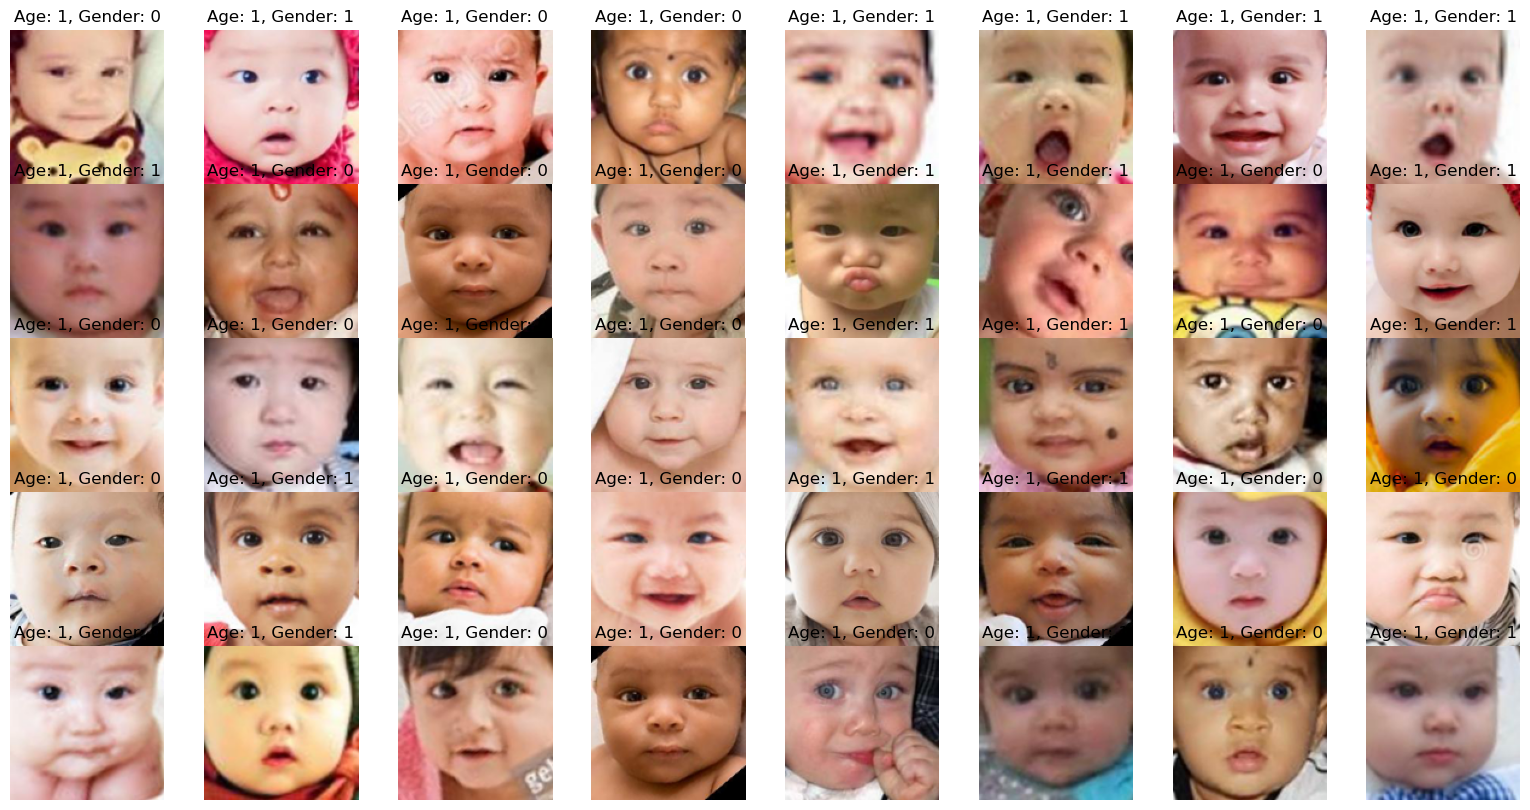

In [12]:
# Filter the rows where age is 1 and show a grid of  images to see if they are babies
age_one_indices = np.where(ages == 1)[0]
age_one_images = images[age_one_indices]
age_one_genders = genders[age_one_indices]
num_images_to_display = 40  # Adjust this number as needed
random_indices = np.random.choice(len(age_one_images), num_images_to_display, replace=False)
sample_images = age_one_images[random_indices]
sample_genders = age_one_genders[random_indices]
# Plot the images in a grid
num_rows = 5
num_cols = num_images_to_display // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i])
    ax.axis('off')
    ax.set_title(f"Age: 1, Gender: {sample_genders[i]}")
plt.subplots_adjust(wspace=0, hspace=0)  # Remove space between images
plt.show()

##### I discover many cropped eyes that are labeled as one years old. it seems that there lies an error in annotation at the root of this

Therefore, i have developed an ImageSelectionApp which displays a grid of images of which you press the faulty ones and then go to the next grid, i made this to quickly filter out obivoulsy faulty images. 

In [13]:
# class ImageSelectionApp:
#     def __init__(self, root, images):
#         self.root = root
#         self.images = images
#         self.approved_images = []
#         self.current_index = 0
#         self.photo_refs = []  # Store references to PhotoImage objects
#         self.selected_images = set()  # Store indices of selected images

#         # Display the first grid of images
#         self.display_images()

#     def display_images(self):
#         self.photo_refs = []  # Clear previous references
#         self.image_labels = []  # Clear previous labels

#         # Create a frame to hold the grid of images
#         self.frame = Frame(self.root)
#         self.frame.grid(row=0, column=0, columnspan=8)

#         for i in range(40):
#             if self.current_index + i < len(self.images):
#                 img_path = self.images[self.current_index + i]
#                 img = Image.open(img_path)
#                 img = img.resize((100, 100), Image.LANCZOS)  # Resize the image
#                 photo = ImageTk.PhotoImage(img)
#                 self.photo_refs.append(photo)  # Store reference to avoid garbage collection

#                 label = Label(self.frame, image=photo)
#                 label.grid(row=i // 8, column=i % 8)
#                 label.bind("<Button-1>", lambda e, idx=self.current_index + i: self.toggle_selection(idx))
#                 self.image_labels.append(label)

#         # Continue button
#         continue_button = Button(self.root, text="Doorgaan", command=self.next_images)
#         continue_button.grid(row=1, column=0, columnspan=8)

#     def toggle_selection(self, idx):
#         if idx in self.selected_images:
#             self.selected_images.remove(idx)
#             self.image_labels[idx % 40].config(borderwidth=0, relief="flat")
#         else:
#             self.selected_images.add(idx)
#             self.image_labels[idx % 40].config(borderwidth=2, relief="solid")

#     def next_images(self):
#         for i in range(40):
#             if self.current_index + i < len(self.images) and (self.current_index + i) not in self.selected_images:
#                 self.approved_images.append(self.images[self.current_index + i])

#         self.current_index += 40
#         if self.current_index < len(self.images):
#             self.frame.destroy()  # Remove current grid of images
#             self.display_images()  # Display the next grid of images
#         else:
#             self.save_results()  # Save results if all images have been reviewed

#     def save_results(self):
#         # Save the approved images to a CSV file
#         with open("approved_images.csv", mode='w', newline='') as file:
#             writer = csv.writer(file)
#             writer.writerow(["Approved Images"])
#             for img in self.approved_images:
#                 writer.writerow([img])
#         self.root.quit()

# def load_images():
#     folder_selected = filedialog.askdirectory()
#     image_paths = [os.path.join(folder_selected, f) for f in os.listdir(folder_selected) if f.endswith(('png', 'jpg', 'jpeg'))]
#     return image_paths

# if __name__ == "__main__":
#     root = Tk()
#     root.title("Afbeelding Goedkeuren/ Afkeuren Tool")
    
#     # Choose the folder with images
#     images = load_images()
    
#     if images:
#         root.after(0, lambda: ImageSelectionApp(root, images))  # Ensure instantiation within the main thread
#         root.mainloop()
#     else:
#         print("Geen afbeeldingen gevonden.")



In [14]:
# def save_results(self):
#     # Sla de goedgekeurde afbeeldingen op in een CSV-bestand
#     with open("approved_images.csv", mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(["Approved Images"])
#         for img in self.approved_images:
#             writer.writerow([img])
#     self.root.quit()

## Race

In [16]:
# Convert one-hot encoded races back to labels 
if races.ndim > 1:
    races = np.argmax(races, axis=1)

race_counts = Counter(races)

# Print the counts
for race, count in race_counts.items():
    print(f"Number of {race_dict[race]}: {count}")

# Visualization of race distribution
race_mapping = [race_dict[i] for i in range(len(race_dict))]
race_values = [race_counts[i] for i in range(len(race_dict))]

# Pie chart
pie_chart = px.pie(
    names=race_mapping,
    values=race_values,
    hole=0.4,
    title="Race Distribution (Donut Chart)",
    height=500
)
pie_chart.show()

Number of White: 10078
Number of Asian: 3434
Number of Black: 4526
Number of Indian: 3975
Number of Others: 1692


#### 2.3 Insights

### Summary of Initial insights from EDA

1. **Dataset Composition and Preprocessing**:
    - The UTKFace dataset contains over 20,000 face images with annotations for age, gender, and ethnicity.
    - Images were preprocessed by resizing to 128x128 pixels and aligning faces.
    - Age, gender, and ethnicity labels were verified by human annotators.

2. **Exploratory Data Analysis (EDA)**:
    - **Age Distribution**:
      - The dataset shows a wide range of ages, with notable peaks at ages 1 and 26.
      - Age 1 appears frequently (4.74%), suggesting potential labeling errors.
      - Age groups were defined and analyzed, revealing an uneven distribution with a higher frequency of ages 20-29.
    - **Gender Distribution**:
      - The dataset is relatively balanced in terms of gender, with 12,391 males and 11,314 females.
    - **Ethnicity Distribution**:
      - The dataset includes five ethnic categories: White, Black, Asian, Indian, and Others.
      - The distribution is imbalanced, with the majority being White (10,078) and the least being Others (1,692).

---
## 3. Construct

With the aid of the Fairlearn library the following fairness metricswill be used :
• Demographic Parity: This metric will help measure
whether the age estimation model’s predictions are in-
dependent of other personal attributes like gender and
ethnicity.
• Equalized Odds: This metric will evaluate whether the
model’s true positive and false positive rates are similar
across different demographic groups.
• Disparate Impact: This metric measures fairness by com-
paring the ratio of positive outcomes between different
demographic groups, with a ratio close to 1.0 indicating
fair treatment.

Epoch 1/10
593/593 [==============================] - 364s 604ms/step - loss: 1.4146 - accuracy: 0.4601 - val_loss: 1.2786 - val_accuracy: 0.4938
Epoch 2/10
593/593 [==============================] - 353s 595ms/step - loss: 1.2167 - accuracy: 0.5154 - val_loss: 1.2348 - val_accuracy: 0.5054
Epoch 3/10
593/593 [==============================] - 354s 597ms/step - loss: 1.1592 - accuracy: 0.5341 - val_loss: 1.2124 - val_accuracy: 0.5085
Epoch 4/10
593/593 [==============================] - 353s 596ms/step - loss: 1.1065 - accuracy: 0.5546 - val_loss: 1.2798 - val_accuracy: 0.4872
Epoch 5/10
593/593 [==============================] - 354s 597ms/step - loss: 1.0690 - accuracy: 0.5703 - val_loss: 1.2817 - val_accuracy: 0.5022
Epoch 6/10
149/149 [==============================] - 71s 475ms/step - loss: 1.2124 - accuracy: 0.5085
Validation Loss: 1.2123830318450928
Validation Accuracy: 0.5085424780845642


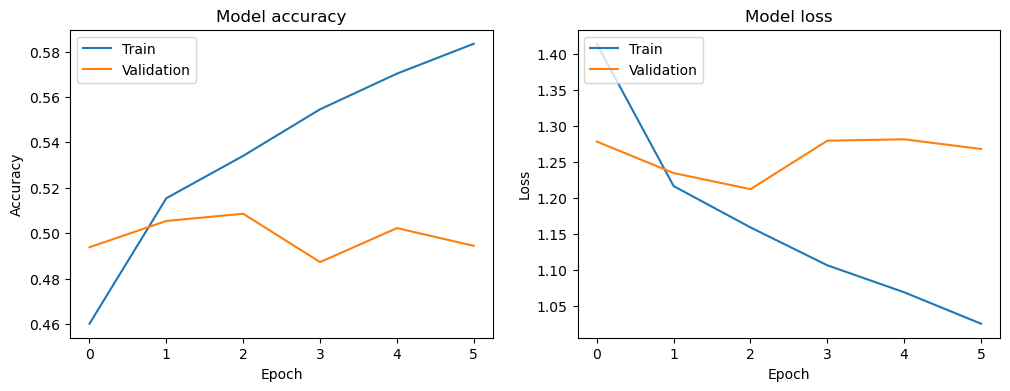

In [ ]:
# Define the number of classes for age groups
num_classes = len(age_groups)

# Load the ResNet-50 model with pre-trained weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Age group classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Convert age groups to one-hot encoding
train_age_groups = to_categorical([map_age_to_group(age) for age in train_ages], num_classes=num_classes)
val_age_groups = to_categorical([map_age_to_group(age) for age in val_ages], num_classes=num_classes)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_images, train_age_groups,
    epochs=10,
    validation_data=(val_images, val_age_groups),
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_images, val_age_groups)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')



In [20]:
from fairlearn.metrics import demographic_parity_difference
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on validation set
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_age_groups, axis=1)
# Define sensitive feature (race)
sensitive_feature = np.argmax(val_races, axis=1) if val_races.ndim > 1 else val_races

def true_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

num_age_groups = val_age_groups.shape[1]  # Assuming one-hot encoded age groups

# Initialize dictionaries to store metrics for each race
dp_dict = {race: [] for race in range(len(race_dict))}
eo_dict = {race: [] for race in range(len(race_dict))}

for age_group in range(num_age_groups):
    binary_y_true = (val_true_labels == age_group).astype(int)
    binary_y_pred = (val_pred_labels == age_group).astype(int)

    for race in range(len(race_dict)):
        binary_sensitive_features = (sensitive_feature == race).astype(int)
        
        # Demographic Parity Difference
        dp = demographic_parity_difference(
            y_true=binary_y_true,
            y_pred=binary_y_pred,
            sensitive_features=binary_sensitive_features
        )
        dp_dict[race].append(dp)
        
        # Equalized Odds Difference
        tpr_race = true_positive_rate(binary_y_true[binary_sensitive_features == 1], 
                                      binary_y_pred[binary_sensitive_features == 1])
        tpr_others = true_positive_rate(binary_y_true[binary_sensitive_features == 0], 
                                        binary_y_pred[binary_sensitive_features == 0])
        fpr_race = false_positive_rate(binary_y_true[binary_sensitive_features == 1], 
                                       binary_y_pred[binary_sensitive_features == 1])
        fpr_others = false_positive_rate(binary_y_true[binary_sensitive_features == 0], 
                                         binary_y_pred[binary_sensitive_features == 0])
        
        tpr_diff = abs(tpr_race - tpr_others)
        fpr_diff = abs(fpr_race - fpr_others)
        eo = max(tpr_diff, fpr_diff)
        eo_dict[race].append(eo)

# Calculate and print average metrics
for race in range(len(race_dict)):
    avg_dp = np.mean(dp_dict[race])
    avg_eo = np.mean(eo_dict[race])
    
    print(f"Average metrics for {race_dict[race]}:")
    print(f"  Average Demographic Parity Difference: {avg_dp:.4f}")
    print(f"  Average Equalized Odds Difference: {avg_eo:.4f}")

149/149 [==============================] - 75s 490ms/step
Average metrics for White:
  Average Demographic Parity Difference: 0.0695
  Average Equalized Odds Difference: 0.1100
Average metrics for Black:
  Average Demographic Parity Difference: 0.0615
  Average Equalized Odds Difference: 0.1489
Average metrics for Asian:
  Average Demographic Parity Difference: 0.0457
  Average Equalized Odds Difference: 0.0965
Average metrics for Indian:
  Average Demographic Parity Difference: 0.0300
  Average Equalized Odds Difference: 0.0989
Average metrics for Others:
  Average Demographic Parity Difference: 0.0389
  Average Equalized Odds Difference: 0.0978


# Interpretation of Fairness Metrics by Race Class

The results of the demographic parity and equalized odds differences for the various racial classes are presented below. These metrics provide insight into the fairness of the model's predictions across different race categories.

| Class | Race            | Demographic Parity Difference | Equalized Odds Difference |
|-------|-----------------|-------------------------------|---------------------------|
| 0     | White           | 0.0695                        | 0.1100                    |
| 1     | Black           | 0.0615                        | 0.1489                    |
| 2     | Asian           | 0.0457                        | 0.0965                    |
| 3     | Indian          | 0.0300                        | 0.0989                    |
| 4     | Others          | 0.0389                        | 0.0978                    |

## Class Analysis

1. **White (Class 0)**:
   - **Demographic Parity Difference (0.0695)**: This moderate difference suggests that White individuals experience a slightly higher rate of positive predictions compared to the overall population, indicating a mild bias in favor of this group.
   - **Equalized Odds Difference (0.1100)**: The second-highest value among all groups, suggesting that the model's accuracy for White individuals varies more significantly across different age groups compared to most other races.

2. **Black (Class 1)**:
   - **Demographic Parity Difference (0.0615)**: This value indicates a slight bias in predictions for Black individuals, though less pronounced than for White individuals.
   - **Equalized Odds Difference (0.1489)**: The highest value among all groups, indicating that the model's accuracy for Black individuals varies the most across different age groups. This suggests potential inconsistencies in the model's performance for this racial category.

3. **Asian (Class 2)**:
   - **Demographic Parity Difference (0.0457)**: A relatively low value, suggesting that predictions for Asian individuals are closer to the overall population average, indicating less bias in this respect.
   - **Equalized Odds Difference (0.0965)**: The lowest value among all groups, indicating that the model's accuracy for Asian individuals is the most consistent across different age groups.

4. **Indian (Class 3)**:
   - **Demographic Parity Difference (0.0300)**: The lowest value among all groups, suggesting that predictions for Indian individuals are closest to the overall population average, indicating the least bias in terms of prediction rates.
   - **Equalized Odds Difference (0.0989)**: A relatively low value, indicating that the model's accuracy for Indian individuals is fairly consistent across different age groups.

5. **Others (Class 4)**:
   - **Demographic Parity Difference (0.0389)**: A relatively low value, suggesting that predictions for individuals in the "Others" category are close to the overall population average.
   - **Equalized Odds Difference (0.0978)**: A relatively low value, indicating that the model's accuracy for the "Others" category is fairly consistent across different age groups.

### Summary

Overall, the model exhibits some disparities in predictions across racial groups, though these disparities are not extreme. The White and Black categories show the highest levels of inconsistency in terms of both demographic parity and equalized odds, while the Asian and Indian categories demonstrate more equitable treatment.

The Indian category shows the least bias in terms of prediction rates (lowest Demographic Parity Difference), while the Asian category shows the most consistent performance across age groups (lowest Equalized Odds Difference). The Black category, however, shows the highest inconsistency in performance across age groups (highest Equalized Odds Difference).

These findings suggest that while the model does not exhibit extreme bias, there is room for improvement, particularly in ensuring more consistent performance for Black individuals across different age groups and in reducing the slight bias in favor of White individuals. Further investigation into the causes of these disparities and potential mitigation strategies would be beneficial to enhance the overall fairness of the model across all racial categories.

C:\Users\noahw\AppData\Local\Temp\ipykernel_29644\1177077800.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\noahw\AppData\Local\Temp\ipykernel_29644\1177077800.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




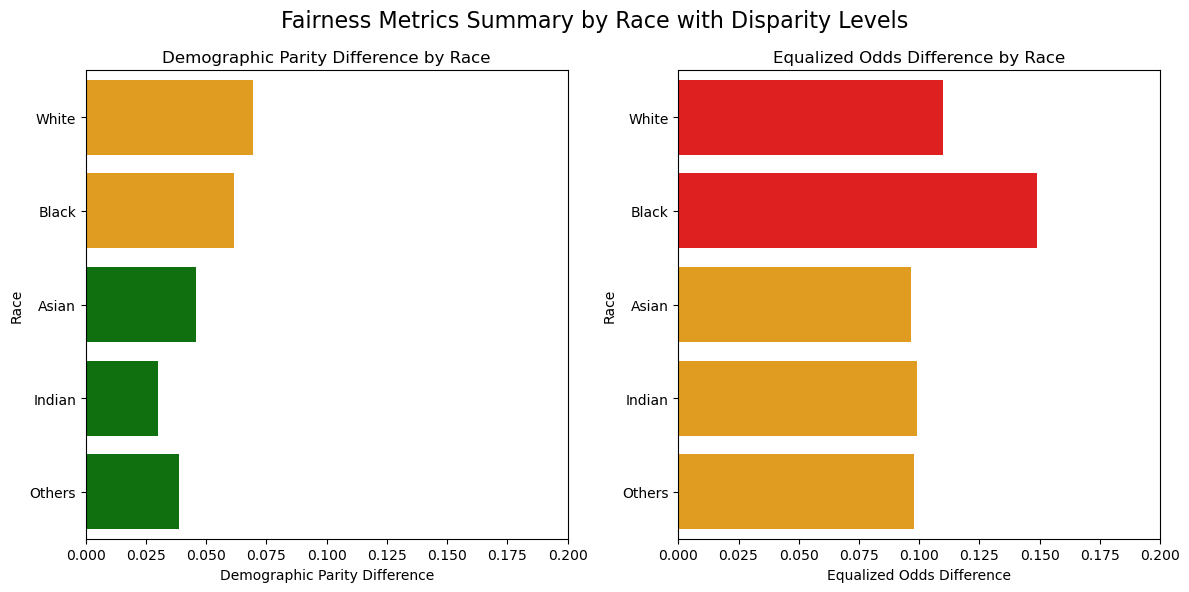

Data saved to fairness_metrics_summary_UTK.csv


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for the groups and disparity values
data = {
    'Race': ["White", "Black", "Asian", "Indian", "Others"],
    'Demographic Parity Difference': [0.0695, 0.0615, 0.0457, 0.0300, 0.0389],
    'Equalized Odds Difference': [0.1100, 0.1489, 0.0965, 0.0989, 0.0978]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Determine colors for each disparity level
def get_color(value, metric):
    if value < 0.05:
        return 'green'   # Low disparity
    elif value < 0.1:
        return 'orange'  # Moderate disparity
    else:
        return 'red'     # High disparity

# Apply colors for both metrics
df['DP Color'] = df['Demographic Parity Difference'].apply(lambda x: get_color(x, 'Demographic Parity Difference'))
df['EO Color'] = df['Equalized Odds Difference'].apply(lambda x: get_color(x, 'Equalized Odds Difference'))

# Convert color columns to lists
dp_colors = df['DP Color'].tolist()
eo_colors = df['EO Color'].tolist()

# Plotting the bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Demographic Parity Difference
sns.barplot(x='Demographic Parity Difference', y='Race', data=df,
            palette=dp_colors, ax=ax[0])
ax[0].set_title("Demographic Parity Difference by Race")
ax[0].set_xlim(0, 0.2)

# Equalized Odds Difference
sns.barplot(x='Equalized Odds Difference', y='Race', data=df,
            palette=eo_colors, ax=ax[1])
ax[1].set_title("Equalized Odds Difference by Race")
ax[1].set_xlim(0, 0.2)

# Adding findings as text labels
fig.suptitle("Fairness Metrics Summary by Race with Disparity Levels", fontsize=16)
plt.tight_layout()
plt.show()

# Save the data as a CSV file
csv_filename = 'fairness_metrics_summary_UTK.csv'
df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

## additional fairness metric analysis

In [22]:
from fairlearn.metrics import demographic_parity_difference

# For a single age group (e.g., the first one)
binary_y_true = (val_true_labels == 0).astype(int)
binary_y_pred = (val_pred_labels == 0).astype(int)

for race in range(len(race_dict)):
    binary_sensitive_features = (sensitive_feature == race).astype(int)
    dp = demographic_parity_difference(
        y_true=binary_y_true,
        y_pred=binary_y_pred,
        sensitive_features=binary_sensitive_features
    )
    print(f"Demographic Parity Difference for {race_dict[race]}: {dp}")

Demographic Parity Difference for White: 0.04466931839449932
Demographic Parity Difference for Black: 0.08577937079924085
Demographic Parity Difference for Asian: 0.1609517992354434
Demographic Parity Difference for Indian: 0.006080464203572181
Demographic Parity Difference for Others: 0.06794227339062753


In [ ]:
#perplexity
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

metric_frame = MetricFrame(metrics=accuracy_score,
                           y_true=val_true_labels,
                           y_pred=val_pred_labels,
                           sensitive_features=sensitive_feature)

print(metric_frame.by_group)
print(metric_frame.difference(method='between_groups'))

sensitive_feature_0
0    0.068473
1    0.012332
2    0.177054
3    0.065637
4    0.110119
Name: accuracy_score, dtype: float64
0.1647219857975838


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
def group_confusion_matrix(y_true, y_pred, sensitive_features):
    unique_groups = np.unique(sensitive_features)
    results = {}
    for group in unique_groups:
        mask = sensitive_features == group
        results[group] = confusion_matrix(y_true[mask], y_pred[mask])
    return results

group_cms = group_confusion_matrix(val_true_labels, val_pred_labels, sensitive_feature)

In [ ]:
def per_class_accuracy(y_true, y_pred, sensitive_features):
    unique_groups = np.unique(sensitive_features)
    unique_classes = np.unique(y_true)
    results = {}
    for group in unique_groups:
        group_mask = sensitive_features == group
        group_results = {}
        for cls in unique_classes:
            class_mask = y_true == cls
            mask = group_mask & class_mask
            group_results[cls] = accuracy_score(y_true[mask], y_pred[mask])
        results[group] = group_results
    return results

per_class_acc = per_class_accuracy(val_true_labels, val_pred_labels, sensitive_feature)

In [ ]:
group_accuracies = metric_frame.by_group
max_difference = group_accuracies.max() - group_accuracies.min()
print(f"Maximum accuracy difference across groups: {max_difference}")

Maximum accuracy difference across groups: 0.1647219857975838


### 4.1 Reflect on these questions while completing this stage


- What key insights emerged from your model?
- What business recommendations do you propose based on the models built?
- What potential recommendations would you make to your manager/company?
- Do you think your model could be improved? Why or why not? How? 
- What business recommendations do you propose based on the models built? 
- Given what you know about the data and the models you were using, what other questions could you address for the team? 
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?

### 4.4 Conclusion


In analyzing UTKFace, it is evident that the dataset reflects notable biases affecting age estimation model performance across different demographic groups. The demographic distribution within UTKFace is imbalanced regarding ethnicity and age representation. This uneven representation introduces a source of systematic error, where the model's performance is optimized for the most prevalent demographics and compromised for underrepresented groups. Such disparities limit the model's generalizability and raise concerns about fairness, as models trained on UTKFace tend to demonstrate reduced accuracy in age prediction for minority groups, potentially amplifying societal biases.

Additionally, this analysis highlights that UTKFace, like many age estimation datasets, lacks thorough documentation regarding its data collection and demographic composition. This lack of transparency complicates efforts to identify and mitigate biases systematically, as the dataset's users may not be fully aware of these intrinsic limitations. Evaluating UTKFace with fairness metrics—such as Demographic Parity and Equalized Odds—provides a quantifiable measure of these biases, reinforcing the necessity for improved dataset documentation and more equitable representation in training data to ensure reliable and fair age estimation models.

Ultimately, the findings underscore that while UTKFace offers a broad dataset for model training, its biases emphasize the critical need for more diverse and well-documented datasets in advancing fairness within facial age estimation.